In [51]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


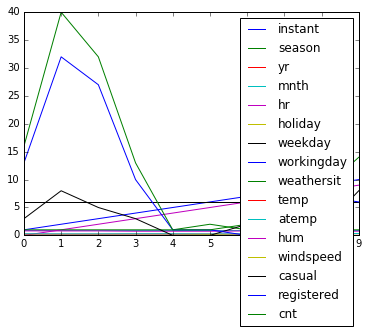

In [52]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

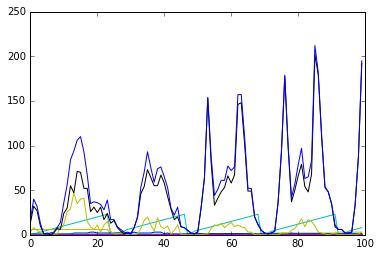

In [64]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, 2:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

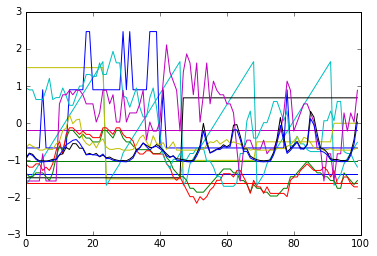

(-2.0933188371550222e-17,
 0.99999999999999978,
 0.99999999999999967,
 (17379, 15),
 dtype('float64'))

In [54]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

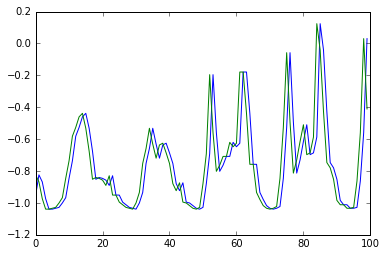

In [63]:
train_data = data_norm[:17000, -1] # the last dim/variable/feature
test_data = data_norm[17000:, -1] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:16999]
Y_train = train_data[1:17000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

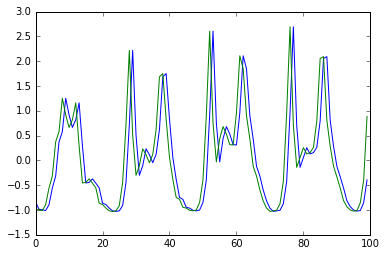

In [56]:
X_valid = test_data[0:378] 
Y_valid = test_data[1:379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [57]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, p_dropout, lam):
        self.D = D
        self.H = H
        self.p_dropout = p_dropout
        self.lam = lam
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches, do_caches = [], [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model)
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            caches.append(cache)
            do_caches.append(do_cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches, do_caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression_reg(model=self.model, y_pred=y, y_train=Y, lam=self.lam)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches, do_caches):
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model.items()}
        grads= {key: np.zeros_like(val) for key, val in self.model.items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[t])
            _, dh, grad = self.backward(dy, dh, caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [58]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M= {key: np.zeros_like(val) for key, val in nn.model.items()}
    R= {key: np.zeros_like(val) for key, val in nn.model.items()}
    
    # Learning decay: suggested by Justin Jhonson in Standford
    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches, do_caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            grads = nn.train_backward(dys, caches, do_caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update the model
            for key in grads.keys(): #key, value: items
                M[key] = l.exp_running_avg(M[key], grads[key], beta1)
                R[key] = l.exp_running_avg(R[key], grads[key]**2, beta2)
                m_k_hat = M[key] / (1. - (beta1** iter))
                r_k_hat = R[key] / (1. - (beta2** iter))
                nn.model[key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (by testing)
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print the model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [59]:
# Hyper-parameters
time_step = 128 # minibatch size: 32, 64, 128, or 256 Cache
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate: 1e-3, 5e-4, 1e-4 - default choices
print_after = 1 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = X_train.shape[1] # X_txn
keep_prob = 0.95 # p_dropout == keep_prob: keeping neurons/units - default 0.95 to 0.9 based on SELU-Dropout
lam = 1e-4 # regularization

# Build the network and learning it or optimizing it using SGD
# def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
net = GRU(D=num_input_units, H=num_hidden_units, p_dropout=keep_prob, lam=lam) #, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 43.91176034, valid loss: 127.54376686
Iter-2, train loss: 34.78603599, valid loss: 177.26449253
Iter-3, train loss: 30.30946133, valid loss: 312.14791185
Iter-4, train loss: 28.56572040, valid loss: 332.90757537
Iter-5, train loss: 27.09613270, valid loss: 318.43866478
Iter-6, train loss: 25.92601560, valid loss: 321.87755266
Iter-7, train loss: 24.54817489, valid loss: 324.40171290
Iter-8, train loss: 24.50608415, valid loss: 327.45639644
Iter-9, train loss: 24.21845551, valid loss: 329.64661588
Iter-10, train loss: 24.27908795, valid loss: 343.62264123
Iter-11, train loss: 20.98794113, valid loss: 352.57643562
Iter-12, train loss: 18.77047124, valid loss: 365.03053240
Iter-13, train loss: 18.64395137, valid loss: 371.65797033
Iter-14, train loss: 17.56889353, valid loss: 393.74967660
Iter-15, train loss: 19.04037125, valid loss: 387.89508621
Iter-16, train loss: 15.81257754, valid loss: 395.46513360
Iter-17, train loss: 17.83213262, valid loss: 394.88192138
Iter-1

Iter-141, train loss: 11.49460617, valid loss: 425.15740937
Iter-142, train loss: 9.94062435, valid loss: 317.21143576
Iter-143, train loss: 7.92041087, valid loss: 391.45963438
Iter-144, train loss: 8.55447081, valid loss: 397.42539347
Iter-145, train loss: 7.51016931, valid loss: 414.83766710
Iter-146, train loss: 6.30642616, valid loss: 438.12243282
Iter-147, train loss: 6.59202989, valid loss: 370.64167317
Iter-148, train loss: 5.96520451, valid loss: 318.14976023
Iter-149, train loss: 7.58939973, valid loss: 316.40076654
Iter-150, train loss: 7.96131121, valid loss: 316.27167660
Iter-151, train loss: 7.38226157, valid loss: 347.24581572
Iter-152, train loss: 10.74572644, valid loss: 345.86738762
Iter-153, train loss: 9.24732781, valid loss: 438.88587863
Iter-154, train loss: 6.29717037, valid loss: 404.95109028
Iter-155, train loss: 6.78071443, valid loss: 312.51296000
Iter-156, train loss: 10.89899137, valid loss: 312.91864750
Iter-157, train loss: 6.77187861, valid loss: 344.210

Iter-280, train loss: 7.31874760, valid loss: 405.73637043
Iter-281, train loss: 5.45319776, valid loss: 387.19054970
Iter-282, train loss: 7.03360378, valid loss: 432.03063790
Iter-283, train loss: 9.77657314, valid loss: 390.96394715
Iter-284, train loss: 8.35589927, valid loss: 419.99589786
Iter-285, train loss: 9.21397990, valid loss: 376.02881973
Iter-286, train loss: 11.03658961, valid loss: 411.69946234
Iter-287, train loss: 6.73118101, valid loss: 405.29783827
Iter-288, train loss: 10.71007453, valid loss: 413.40532920
Iter-289, train loss: 6.57929270, valid loss: 422.47341517
Iter-290, train loss: 6.33996721, valid loss: 433.42258313
Iter-291, train loss: 6.62082342, valid loss: 437.48768077
Iter-292, train loss: 5.86347864, valid loss: 389.88815225
Iter-293, train loss: 8.07909372, valid loss: 403.72522208
Iter-294, train loss: 8.78237275, valid loss: 406.43162422
Iter-295, train loss: 6.60727996, valid loss: 414.50600246
Iter-296, train loss: 6.71740793, valid loss: 407.8944

Iter-419, train loss: 5.77085058, valid loss: 402.26762671
Iter-420, train loss: 9.60755643, valid loss: 423.63690412
Iter-421, train loss: 6.08981784, valid loss: 439.33628319
Iter-422, train loss: 8.99551457, valid loss: 446.76312703
Iter-423, train loss: 7.80752081, valid loss: 402.45933361
Iter-424, train loss: 6.02275767, valid loss: 450.23602200
Iter-425, train loss: 6.87428677, valid loss: 428.73648062
Iter-426, train loss: 5.84238891, valid loss: 430.07087242
Iter-427, train loss: 5.47435745, valid loss: 457.53125108
Iter-428, train loss: 7.75595094, valid loss: 432.57965710
Iter-429, train loss: 6.94484436, valid loss: 436.33252263
Iter-430, train loss: 7.03066520, valid loss: 419.86687536
Iter-431, train loss: 14.31956081, valid loss: 401.29942281
Iter-432, train loss: 6.47174780, valid loss: 439.74505735
Iter-433, train loss: 6.98061539, valid loss: 391.58488933
Iter-434, train loss: 8.62656002, valid loss: 423.62967573
Iter-435, train loss: 8.76867674, valid loss: 412.47844

Iter-558, train loss: 10.22151176, valid loss: 422.41787476
Iter-559, train loss: 9.49473716, valid loss: 377.96731619
Iter-560, train loss: 6.11934802, valid loss: 420.04924976
Iter-561, train loss: 8.18273639, valid loss: 448.72445096
Iter-562, train loss: 6.00912393, valid loss: 352.52195105
Iter-563, train loss: 7.45943820, valid loss: 380.69930133
Iter-564, train loss: 11.12007776, valid loss: 420.34793194
Iter-565, train loss: 6.82957719, valid loss: 440.03961014
Iter-566, train loss: 9.52830505, valid loss: 390.50397114
Iter-567, train loss: 7.91988736, valid loss: 441.98995784
Iter-568, train loss: 8.05756121, valid loss: 402.16107201
Iter-569, train loss: 6.15313900, valid loss: 392.05976223
Iter-570, train loss: 7.23225293, valid loss: 379.10623772
Iter-571, train loss: 10.35101044, valid loss: 413.90580877
Iter-572, train loss: 5.91715517, valid loss: 377.53740182
Iter-573, train loss: 5.58554222, valid loss: 335.96898797
Iter-574, train loss: 6.17299413, valid loss: 398.675

Iter-697, train loss: 10.63814351, valid loss: 313.33767867
Iter-698, train loss: 5.04764282, valid loss: 304.47741867
Iter-699, train loss: 5.51390769, valid loss: 285.82772005
Iter-700, train loss: 6.17413732, valid loss: 326.77780496
Iter-701, train loss: 7.44654871, valid loss: 240.48007725
Iter-702, train loss: 9.85291766, valid loss: 227.81610804
Iter-703, train loss: 8.52864141, valid loss: 237.83224281
Iter-704, train loss: 6.72862982, valid loss: 252.39117187
Iter-705, train loss: 6.50170401, valid loss: 286.96503074
Iter-706, train loss: 7.06549170, valid loss: 214.55153025
Iter-707, train loss: 7.96490714, valid loss: 281.31107372
Iter-708, train loss: 5.96740764, valid loss: 283.92033585
Iter-709, train loss: 9.30743021, valid loss: 207.72432105
Iter-710, train loss: 9.01560912, valid loss: 233.90514079
Iter-711, train loss: 9.37971735, valid loss: 314.84792419
Iter-712, train loss: 6.44019969, valid loss: 285.76202896
Iter-713, train loss: 6.44265415, valid loss: 242.75381

Iter-836, train loss: 11.05572970, valid loss: 214.86028828
Iter-837, train loss: 6.16208904, valid loss: 275.52873115
Iter-838, train loss: 6.17737632, valid loss: 221.87559491
Iter-839, train loss: 7.19217647, valid loss: 214.57943820
Iter-840, train loss: 7.04155504, valid loss: 302.94413057
Iter-841, train loss: 6.48110014, valid loss: 223.78954091
Iter-842, train loss: 5.30874224, valid loss: 254.68982767
Iter-843, train loss: 6.45382506, valid loss: 248.03531699
Iter-844, train loss: 12.45257694, valid loss: 257.66305987
Iter-845, train loss: 6.82693836, valid loss: 224.33706783
Iter-846, train loss: 7.48129322, valid loss: 289.01338538
Iter-847, train loss: 6.10086338, valid loss: 245.11046901
Iter-848, train loss: 6.48748132, valid loss: 247.68109086
Iter-849, train loss: 7.58534154, valid loss: 227.43055374
Iter-850, train loss: 7.13109607, valid loss: 163.66639070
Iter-851, train loss: 8.63992852, valid loss: 231.91581720
Iter-852, train loss: 6.35591150, valid loss: 188.2591

Iter-975, train loss: 10.58871787, valid loss: 300.65143126
Iter-976, train loss: 9.45034008, valid loss: 162.10958314
Iter-977, train loss: 6.37611640, valid loss: 318.37486189
Iter-978, train loss: 5.90898591, valid loss: 383.15531756
Iter-979, train loss: 6.08074785, valid loss: 288.82332674
Iter-980, train loss: 7.04311184, valid loss: 249.00925304
Iter-981, train loss: 5.34346947, valid loss: 314.53488697
Iter-982, train loss: 5.79933593, valid loss: 338.76128185
Iter-983, train loss: 6.74916889, valid loss: 286.10256704
Iter-984, train loss: 5.71570419, valid loss: 231.04235134
Iter-985, train loss: 7.03745304, valid loss: 355.60560653
Iter-986, train loss: 6.66548685, valid loss: 290.21073565
Iter-987, train loss: 5.60886632, valid loss: 394.05799013
Iter-988, train loss: 10.72094715, valid loss: 395.02147098
Iter-989, train loss: 9.73426807, valid loss: 448.57469809
Iter-990, train loss: 6.48439189, valid loss: 256.06760096
Iter-991, train loss: 6.04666496, valid loss: 312.8534

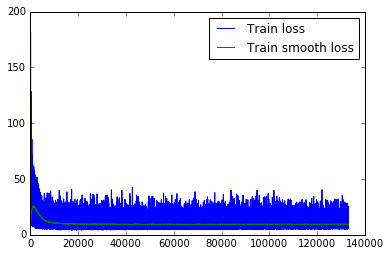

In [60]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

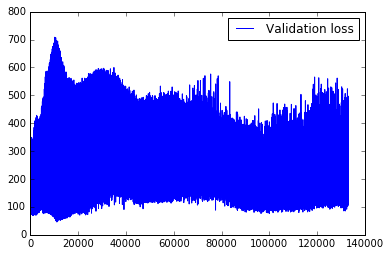

In [61]:
import matplotlib.pyplot as plt

plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

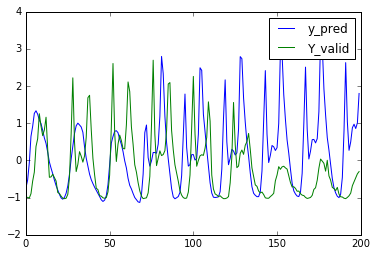

In [66]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred[:200], label='y_pred')
plt.plot(Y_valid[:200], label='Y_valid')
# plt.plot(X_valid[:100], label='X_valid')
plt.legend()
plt.show()